### Code du professeur fonctionnel ###


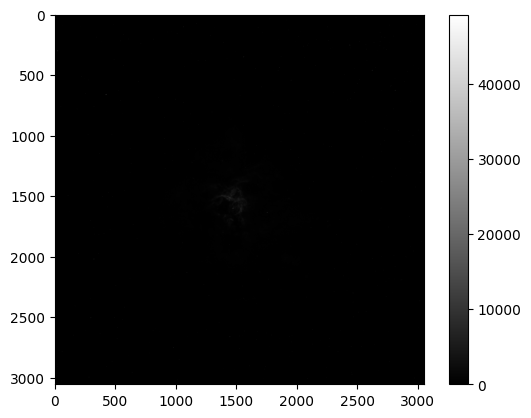

In [ ]:
from astropy.io import fits
import matplotlib.pyplot as plt 

data = fits.getdata('image_test/Tarantula_Nebula-sii.fit')

plt.imshow(data , cmap='gray')
plt.colorbar()
plt.show()